In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.fft import * 
from util.phantom import * 
from util.coil import * 
from util.tool import * 
import nibabel as nib
import os
from tqdm.notebook import tqdm

In [2]:
import scipy.io
def get_tissue_images(slices):
    tissuetype = ['graymatter', 'deep_graymatter', 'whitematter', 'csf']
    T2 = [110, 100, 60, 1500]
    T2s = [40, 45, 50, 1000]
    mat = scipy.io.loadmat('../lib/resource/data/tissue_images/tissue_images.mat')
    tissues = mat.get("tissue_images")[:,:,slices,:]
    return np.squeeze(tissues), tissuetype

def brain_tissue(slices, coils):
    tissues,tissuetype = get_tissue_images(slices)
    if (coils== 1): return tissues,tissuetype, T2, T2s
    tissues = np.repeat(tissues[:, :,  np.newaxis,:], coils, axis=-2)
    coils = generate_birdcage_sensitivities(matrix_size = 222,number_of_coils = coils)
    tissues = tissues *  np.repeat(coils[...,np.newaxis], 4, axis = -1)
    return tissues,tissuetype

def simulate_blip_down(ideal_image, field):
    [ny,nx] = ideal_image.shape
    image = np.zeros([ny, nx], dtype = complex)
    for y in range(ny):
        modulation = np.exp(1j * t * field[y])
        modulation = np.repeat(modulation[:,None], nx, -1)
        tmp = ideal_image * modulation 
        image[y] = fft2c(tmp)[y]
    contracted = ifft2c(image)
    return contracted

def simulate_blip_up(ideal_image, field):
    [ny,nx] = ideal_image.shape
    image = np.zeros([ny, nx], dtype = complex)
    for y in range(ny-1,0,-1):
        modulation = np.exp(1j * t * field[ny-y])
        modulation = np.repeat(modulation[:,None], nx, -1)
        tmp = ideal_image * modulation 
        image[y] = fft2c(tmp)[y]
    extended = ifft2c(image)
    return extended

In [3]:
tissues,tissuetype = brain_tissue(70, 4)
ny, nx, nc, nt = tissues.shape
G = 0.005
fov = ny
dwell_time = 1
gamma = 2* np.pi * 42.58
t = np.linspace(-1, 1, nx) * 1E-3 * fov
phase_inc = gamma * G * dwell_time
field = np.zeros([ny, nx], dtype = complex)
for y in range(ny):
    field[y] =  phase_inc * y 

  0%|          | 0/145 [00:00<?, ?it/s]

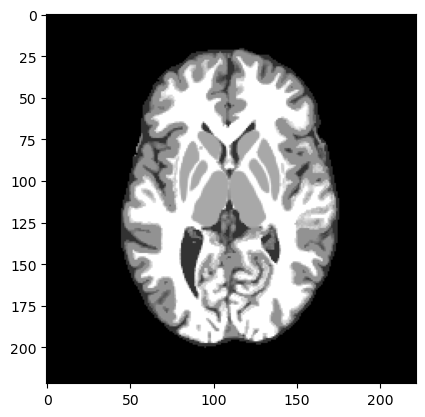

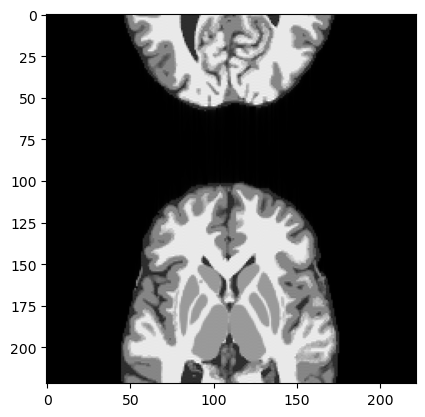

In [ ]:
brain_blip_down = np.zeros([ny,nx,145])
brain_blip_up = np.zeros([ny,nx,145])
for sli in tqdm(range(145)):
    tissues,issuetype = brain_tissue(70, 4)
    TE = 100
    ideal_image = np.zeros([ny, nx, nc], dtype = complex)
    for t in range(nt):
        ideal_image += tissues[...,t] * np.exp(TE/t2(tissuetype[t]))
    ideal_image = rsos(ideal_image) 
    show(ideal_image)
    show(np.abs(simulate_blip_down(ideal_image, field)))
    show(np.abs(simulate_blip_up(ideal_image, field)))
    brain_blip_down[...,sli] = np.abs(simulate_blip_down(ideal_image, field))
    brain_blip_up[...,sli] = np.abs(simulate_blip_up(ideal_image, field))

In [ ]:
blip_up_data = brain_blip_up
blip_down_data = brain_blip_down

In [14]:
path = "../lib/EPI_DISTORTION/"
if os.path.isdir(path) is False:
    os.mkdir(path)
new_image = nib.Nifti1Image(blip_up_data, affine=np.eye(4))
nib.save(new_image,path+ "blip_up.nii")
new_image = nib.Nifti1Image(blip_down_data, affine=np.eye(4))
nib.save(new_image, path+"blip_down.nii")
with open(path+'acqparams.txt', 'w') as f:
    f.write('0 -1 0 '+str(10E-6*(ny-1)*nx)[:5])
    f.write('\n')
    f.write('0 1 0 '+str(10E-6*(ny-1)*nx)[:5])

In [ ]:
merged_file = "merged"
%cd  ../lib/EPI_DISTORTION/
commands = []
commands.append("fslmerge -t "+merged_file+".nii.gz blip_down.nii blip_up.nii")
commands.append("topup --imain="+merged_file+" --datain=acqparams.txt --config=b02b0.cnf --out=topup_bfield")
commands.append("applytopup --imain=blip_down,blip_up --topup=topup_bfield --datain=acqparams.txt --inindex=1,2 --out=fsl_corrected")
for c in commands:
    os.system(c)

/home/zimu/Desktop/mri_recon/lib/EPI_DISTORTION


In [ ]:
fieldmap = nib.load('../lib/EPI_DISTORTION/topup_bfield.nii.gz').get_fdata()
show(fieldmap)

In [ ]:
corrected = nib.load('../lib/EPI_DISTORTION/fsl_corrected.nii.gz').get_fdata()
show(corrected)